Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [7]:
import random
from random import choices
from copy import copy
import numpy as np
import lab9_lib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from colorama import Fore, Style


# Local Search:
Local search is a heuristic method for solving computationally hard optimization problems. Local search can be used on problems that can be formulated as finding a solution maximizing a criterion among a number of candidate solutions. Local search algorithms move from solution to solution in the space of candidate solutions (the search space) by applying local changes, until a solution deemed optimal is found or a time bound is elapsed.

In [8]:
l = 1000
problems = [1, 2, 5, 10]
half_pop_size = 10
µ = 2 * half_pop_size

## Implementation:
Idea: with the fitness function I can see which pieces of string are important and which are not, and therefore I can preserve the important pieces and throw away the useless ones.

IMPORTANT: PROMOTE DIVERSITY (I can do it in the selection, crossover and mutation)
* distance metric: 
  - how far the individual is from a subset of the population to the whole population
  - from a single individual
* property of the population

3 levels of diversity:
* phenotype
* genotype
* fitness

In [9]:
# Evaluate diversity (how many different elements we have in the genome)
def compute_diversity(e1, e2):
    xor_res = e1 ^ e2
    return np.sum(xor_res) / l


In [10]:
# I used this values to evaluate my parent selection
fit1, fit2 = 0, 0
max1, max2 = 0, 0
diff_matrix = np.zeros((µ, µ))
fit_matrix = np.zeros((µ, µ))
saved_matrices = []
saved_matrices_2 = []


def print_matrix():
    # Print the diversity matrix with highlighted element
    '''print("THIS BEST DERIVES FROM THE FOLLOWING INDIVIDUALS (than they are mutated):")
    for i in range(µ):
        for j in range(µ):
            if (i, j) in [(fit1, fit2), (max1, max2)]:
                print(f"{Fore.YELLOW if (i, j) == (fit1, fit2) else Fore.RED}{diff_matrix[i][j]}{Style.RESET_ALL}", end=" ")
            else:
                print(diff_matrix[i][j], end=" ")
        print()
    '''
    print(f"(MOST DIFFERENT):\t{max1}, {max2}\t(without fitness)") #red
    print(f"(INDIVIDUALS SELECTED):\t{fit1}, {fit2}\t(with fitness)") #yellow
    saved_matrices.append(np.copy(diff_matrix))
    saved_matrices_2.append(np.copy(fit_matrix))

def init_population():
    return np.array([(np.array(choices([0, 1], k=l)), 0.0) for _ in range(µ)], dtype=object)

def evaluate_population(population, fitness):
    return np.array([(individual[0], fitness(individual[0])) for individual in population], dtype=object)

def select_with_replacement(population):
    global fit1, fit2, max1, max2, diff_matrix
    # find the individuals with 
    # the highest fitness and the highest diversity
    div_matr = np.zeros((µ, µ))
    for i1, p1 in enumerate(population):
        for i2, p2 in enumerate(population):
            if i1 != i2:
                #the matrix is not symmetric since is added only for p2[1]
                div_matr[i1][i2] = (compute_diversity(p1[0], p2[0]) + p2[1]) / 2
                fit_matrix[i1][i2] = div_matr[i1][i2]
                diff_matrix[i1][i2] = compute_diversity(p1[0], p2[0])

    # find index of the individuals with highest fitness and highest diversity
    i1, i2 = np.unravel_index(np.argmax(div_matr), div_matr.shape)
    fit1, fit2 = i1, i2
    max1, max2 = np.unravel_index(np.argmax(diff_matrix), div_matr.shape)
    
    return population[i1], population[i2]

def crossover_cyclic_shift(parent1, parent2):
    # a two (rand) point crossover for now
    # swapping of two substrings of the same len but in random position
    # I want try to implement a circular translated swapping
    v = parent1[0]
    w = parent2[0]
    c = random.randint(0, l)
    d = random.randint(0, l)
    s = random.randint(0, l)
    if c < d:
        for i in range(c, d):
            v[i%l], w[(i+s)%l] = w[(i+s)%l], v[i%l]
    else:
        for i in range(c, d+l):
            v[i%l], w[(i+s)%l] = w[(i+s)%l], v[i%l]
    return (v, 0.0), (w, 0.0)

def std_crossover(parent1, parent2):
    # a two (rand) point crossover for now
    # swapping of two substrings of the same len but in random position
    # I want try to implement a circular translated swapping
    v = parent1[0]
    w = parent2[0]
    c = random.randint(0, l)
    d = random.randint(0, l)
    if c > d:
        c, d = d, c
    if c!=d:
        v[c:d], w[c:d] = w[c:d], v[c:d]
    return (v, 0.0), (w, 0.0)

def mutate(individual, mutation_prob=0.5):
    # bit flip mutation for now
    v = individual[0]
    for i in range(l):
        if mutation_prob >= random.random():
            v[i] = 1 - v[i]
    return individual

In [11]:
def plot():
    num_matrices = len(saved_matrices)
    if num_matrices != 0:
        if num_matrices == 1:
            fig, axes = plt.subplots(1, 1, figsize=(4, 4))
            axes = [axes]  # Convert single subplot to a list for iteration
        else:
            fig, axes = plt.subplots(1, num_matrices, figsize=(num_matrices * 4, 4))
        for i, matrix in enumerate(saved_matrices):
            axes[i].imshow(matrix, cmap='viridis')
            axes[i].set_title(f'Matrice {i+1}')
        for i, matrix in enumerate(saved_matrices):
            im = axes[i].imshow(matrix, cmap='viridis')  # Usa 'hot' come mappa di colori
            axes[i].set_title(f'Matrice {i+1}')
        fig.colorbar(im, ax=axes, orientation='vertical')    
        plt.show()

def genetic_algorithm(fitness, crossover):
    global saved_matrices
    saved_matrices = []
    Best = None
    # 1. Initialize population
    population = init_population()
    population = evaluate_population(population, fitness)
    # 2. Repeat
    found = -1
    x = -1
    #for i in tqdm(range(100)):
    for i in range(100):
        for p in population:
            if Best is None or p[1] > Best[1]:
                if i!=0:
                    print_matrix()
                print(f"Best: {p[0][0:5]}...\tfitness:{p[1]}\tcalls:{fitness._calls}")
                Best = p
                found = fitness._calls
                x = i
        
        if Best is not None and Best[1]==1:
            break
        
        q = list()
        for _ in range(µ//2):
            # 2.1 Select parents
            parent_a, parent_b = select_with_replacement(population)
            # 2.2 Crossover
            child_a, child_b = crossover(copy(parent_a), copy(parent_b))
            
            # 2.3 Mutate
            mutated_a = mutate(child_a)
            mutated_b = mutate(child_b)
            q.append(mutated_a)
            q.append(mutated_b)
            
        population = evaluate_population(q, fitness)
    
    # 4. Return best individual
    plot()
    return Best, found, x

### Using CYCLIC SHIFT CROSSOVER:

Problem 1:
Best: [1 1 1 0 1]...	fitness:0.504	calls:20
Best: [1 0 0 1 0]...	fitness:0.511	calls:20
Best: [1 1 1 1 1]...	fitness:0.533	calls:20
(MOST DIFFERENT):	0, 2	(without fitness)
(INDIVIDUALS SELECTED):	2, 0	(with fitness)
Best: [1 1 1 1 1]...	fitness:0.548	calls:800


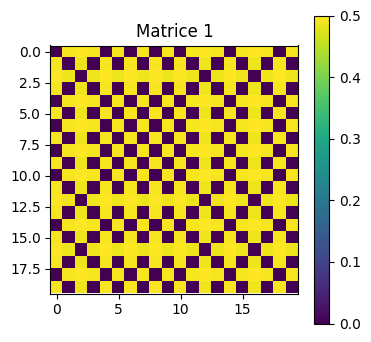

-------------------------------------
Problem 2:
Best: [1 1 0 1 1]...	fitness:0.2311	calls:20
Best: [0 0 1 1 0]...	fitness:0.2333	calls:20
Best: [1 0 1 0 1]...	fitness:0.2361	calls:20
Best: [1 1 0 0 0]...	fitness:0.508	calls:20
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 2	(with fitness)
Best: [1 1 1 0 0]...	fitness:0.522	calls:700
(MOST DIFFERENT):	0, 3	(without fitness)
(INDIVIDUALS SELECTED):	0, 3	(with fitness)
Best: [1 0 1 0 0]...	fitness:0.528	calls:1180


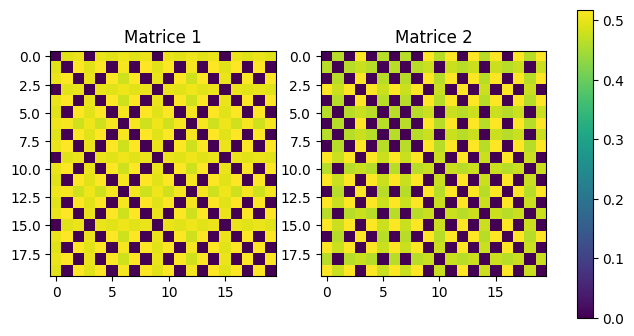

-------------------------------------
Problem 5:
Best: [1 0 1 0 0]...	fitness:0.0946596	calls:20
Best: [0 0 0 0 1]...	fitness:0.0992251	calls:20
Best: [1 1 1 1 0]...	fitness:0.1026293	calls:20
Best: [1 0 0 1 0]...	fitness:0.204593	calls:20
(MOST DIFFERENT):	8, 13	(without fitness)
(INDIVIDUALS SELECTED):	7, 9	(with fitness)
Best: [1 0 0 0 1]...	fitness:0.21881899999999999	calls:40
(MOST DIFFERENT):	0, 7	(without fitness)
(INDIVIDUALS SELECTED):	0, 7	(with fitness)
Best: [0 0 1 0 0]...	fitness:0.29261000000000004	calls:120
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 1 0 0 0]...	fitness:0.30431	calls:620
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 0 0 0 0]...	fitness:0.32121	calls:780


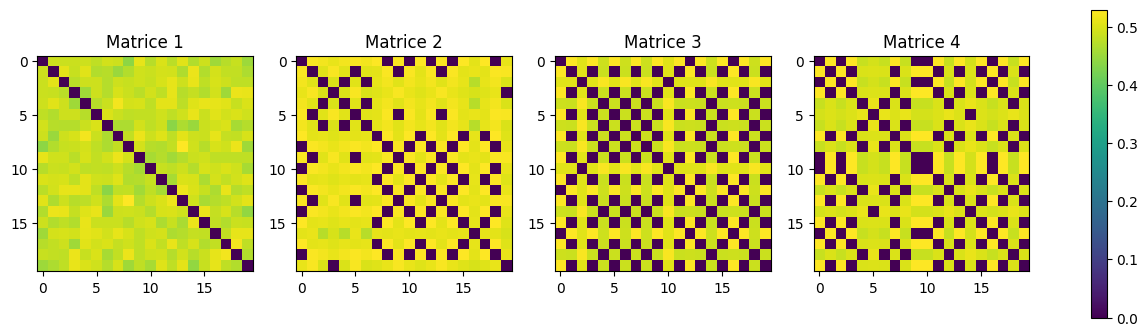

-------------------------------------
Problem 10:
Best: [0 1 0 1 1]...	fitness:0.048136802226999995	calls:20
Best: [1 0 0 0 0]...	fitness:0.050012368909	calls:20
Best: [0 1 1 1 1]...	fitness:0.055382234567	calls:20
Best: [1 0 1 0 1]...	fitness:0.10780013896	calls:20
(MOST DIFFERENT):	7, 11	(without fitness)
(INDIVIDUALS SELECTED):	11, 12	(with fitness)
Best: [0 0 0 1 0]...	fitness:0.11160114461000001	calls:40
(MOST DIFFERENT):	0, 4	(without fitness)
(INDIVIDUALS SELECTED):	0, 4	(with fitness)
Best: [0 0 1 0 0]...	fitness:0.20624889899999999	calls:120


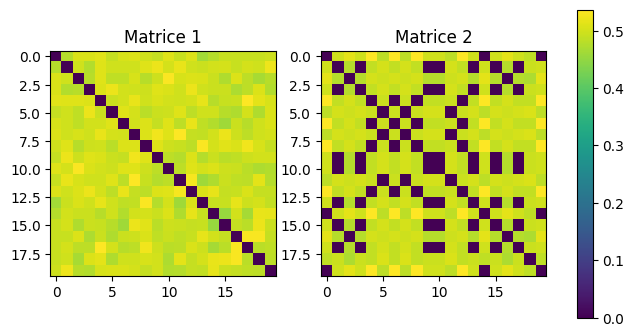

-------------------------------------
Problem	1:	54.80%,	Calls:	2020,	Best found at 	120 fitness calls,	at iteration 5
Problem	2:	52.80%,	Calls:	2020,	Best found at 	120 fitness calls,	at iteration 5
Problem	5:	32.12%,	Calls:	2020,	Best found at 	120 fitness calls,	at iteration 5
Problem	10:	20.62%,	Calls:	2020,	Best found at 	120 fitness calls,	at iteration 5
-------------------------------------


In [12]:
my_list = list()
found = -1
fitness = None
for prob in problems:
    print(f"Problem {prob}:")
    fitness = lab9_lib.make_problem(prob)
    b, found, i = genetic_algorithm(fitness, crossover_cyclic_shift)
    my_list.append((prob, b[1], fitness.calls))
    print("-------------------------------------")

for m in my_list:
    print(f"Problem\t{m[0]}:\t{m[1]:.2%},\tCalls:\t{m[2]},\tBest found at \t{found} fitness calls,\tat iteration {i}")
print("-------------------------------------")

### Using STD CROSSOVER:

Problem 1:
Best: [0 1 1 1 0]...	fitness:0.496	calls:20
Best: [1 0 1 0 1]...	fitness:0.502	calls:20
Best: [0 1 0 0 1]...	fitness:0.526	calls:20
(MOST DIFFERENT):	15, 16	(without fitness)
(INDIVIDUALS SELECTED):	16, 15	(with fitness)
Best: [1 1 0 1 0]...	fitness:0.528	calls:80
(MOST DIFFERENT):	15, 16	(without fitness)
(INDIVIDUALS SELECTED):	16, 15	(with fitness)
Best: [1 0 0 1 0]...	fitness:0.53	calls:80
(MOST DIFFERENT):	3, 8	(without fitness)
(INDIVIDUALS SELECTED):	8, 3	(with fitness)
Best: [1 1 1 0 1]...	fitness:0.54	calls:180


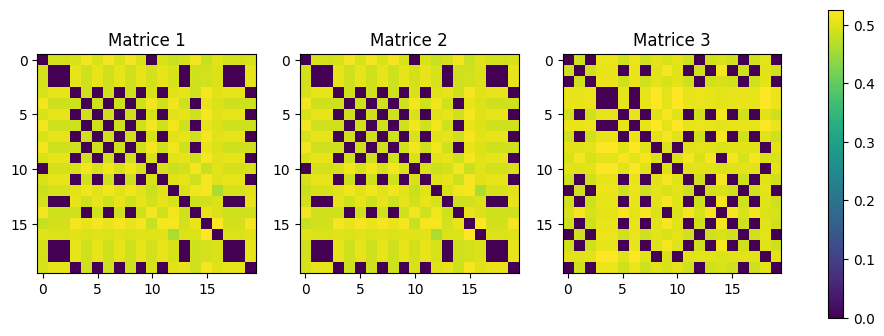

Problem 2:
Best: [0 0 1 0 1]...	fitness:0.2512	calls:20
Best: [1 1 0 1 1]...	fitness:0.502	calls:20
(MOST DIFFERENT):	0, 6	(without fitness)
(INDIVIDUALS SELECTED):	6, 0	(with fitness)
Best: [1 1 0 0 1]...	fitness:0.52	calls:1200


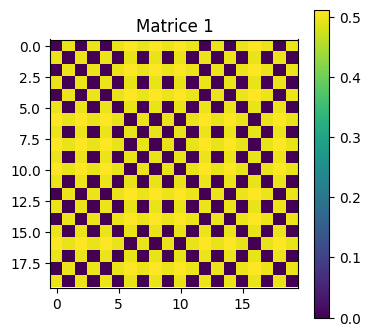

Problem 5:
Best: [0 1 0 0 0]...	fitness:0.0969144	calls:20
Best: [1 1 1 1 0]...	fitness:0.09743890000000001	calls:20
Best: [1 0 1 1 1]...	fitness:0.09971580000000001	calls:20
Best: [1 0 0 1 0]...	fitness:0.1051581	calls:20
Best: [1 1 0 1 1]...	fitness:0.10585720000000001	calls:20
(MOST DIFFERENT):	2, 8	(without fitness)
(INDIVIDUALS SELECTED):	0, 9	(with fitness)
Best: [0 0 1 0 0]...	fitness:0.189247	calls:40
(MOST DIFFERENT):	0, 2	(without fitness)
(INDIVIDUALS SELECTED):	0, 2	(with fitness)
Best: [0 1 0 1 1]...	fitness:0.196912	calls:120
(MOST DIFFERENT):	0, 2	(without fitness)
(INDIVIDUALS SELECTED):	0, 2	(with fitness)
Best: [1 1 1 1 0]...	fitness:0.20039400000000002	calls:120
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [1 0 1 0 1]...	fitness:0.20650200000000002	calls:260
(MOST DIFFERENT):	1, 2	(without fitness)
(INDIVIDUALS SELECTED):	1, 2	(with fitness)
Best: [0 0 0 0 0]...	fitness:0.206915	calls:780
(MOST DIFFERENT):	1, 9	(without f

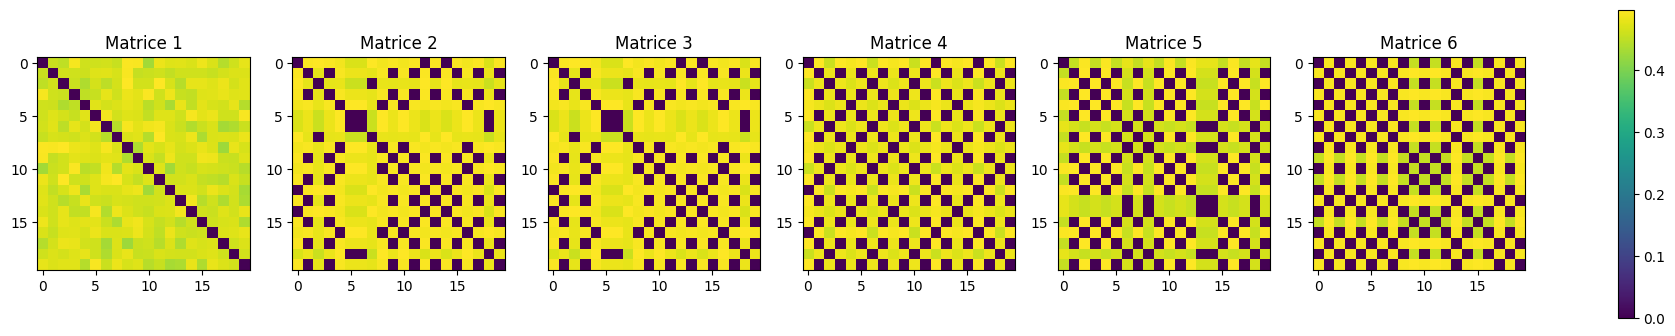

Problem 10:
Best: [0 0 1 0 1]...	fitness:0.1532224585	calls:20
(MOST DIFFERENT):	0, 1	(without fitness)
(INDIVIDUALS SELECTED):	0, 1	(with fitness)
Best: [0 0 0 1 0]...	fitness:0.25435573	calls:980


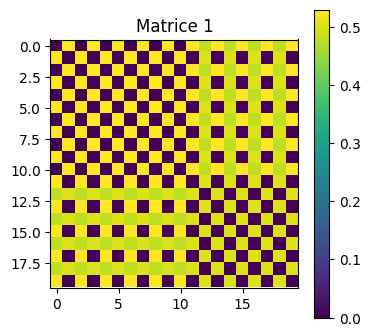

Problem	1:	54.00%,	Calls:	2020,	Best found at 	980 fitness calls,	at iteration 48
Problem	2:	52.00%,	Calls:	2020,	Best found at 	980 fitness calls,	at iteration 48
Problem	5:	21.58%,	Calls:	2020,	Best found at 	980 fitness calls,	at iteration 48
Problem	10:	25.44%,	Calls:	2020,	Best found at 	980 fitness calls,	at iteration 48
-------------------------------------


In [13]:
my_list = list()
found = -1
fitness = None
for prob in problems:
    print(f"Problem {prob}:")
    fitness = lab9_lib.make_problem(prob)
    b, found, i = genetic_algorithm(fitness, std_crossover)
    my_list.append((prob, b[1], fitness.calls))
for m in my_list:
    print(f"Problem\t{m[0]}:\t{m[1]:.2%},\tCalls:\t{m[2]},\tBest found at \t{found} fitness calls,\tat iteration {i}")
print("-------------------------------------")

In [14]:
for i, prob in enumerate(problems):
    print(f"Problem {prob}:")

    fitness = lab9_lib.make_problem(prob)
    for n in range(10):
        ind = choices([0, 1], k=1000)
        print(f"{''.join(str(g) for g in ind[0:5])}... | {fitness(ind):.2%}")

    print(fitness.calls)

    print("-------------------------------------")


Problem 1:
00001... | 48.60%
10110... | 53.00%
11001... | 48.80%
11010... | 52.20%
00001... | 50.40%
00111... | 48.00%
00110... | 48.90%
00101... | 50.30%
00010... | 49.90%
00000... | 48.80%
10
-------------------------------------
Problem 2:
10100... | 22.87%
10100... | 21.98%
01011... | 24.01%
10110... | 49.00%
01110... | 22.18%
11011... | 23.10%
00111... | 22.72%
11101... | 22.56%
00011... | 22.64%
01000... | 23.43%
10
-------------------------------------
Problem 5:
11001... | 10.35%
01100... | 10.39%
10000... | 10.11%
01001... | 9.91%
01010... | 10.15%
01000... | 9.27%
00110... | 9.69%
01101... | 9.71%
11010... | 9.46%
10110... | 9.79%
10
-------------------------------------
Problem 10:
10101... | 5.26%
11101... | 5.17%
00001... | 5.18%
11010... | 10.43%
00100... | 5.28%
10110... | 5.40%
01001... | 5.22%
11000... | 10.78%
10111... | 5.36%
11101... | 5.41%
10
-------------------------------------


In [15]:
fitness = lab9_lib.make_problem(1)
for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")

print(fitness.calls)

00000010000010100000010100100010001101101011011000: 32.00%
10110011010000111111100011100010001000001111110000: 48.00%
01001010001001110101100001011111001101101100100110: 50.00%
10010011101100101000111101010010100011000111101000: 48.00%
11101101110001001101111011000000110000010001111001: 50.00%
11111111100010001001010100000000011001101110010000: 44.00%
11101100100000111101100101100101111111001000111010: 56.00%
11101101101100001110010010011011101001000000101111: 52.00%
00010011011011001000001110001011111110100001010101: 48.00%
11111010000110000000110101100011111011100011000001: 48.00%
10
